## GMM pose space model with scalar morph

### Setup

In [1]:
%load_ext autoreload
%autoreload 3 --print

In [2]:
from kpsn.models.morph import scalar
from kpsn.models.pose import gmm
from kpsn.models import joint_model
from kpsn.fitting import em
from kpsn import models
from kpsn import util

from mph.generative.test.visualize import mixtures
from mph.generative.test.visualize import fitting
from mph.generative.test.visualize import morphs as viz_morphs

import jax.numpy as jnp
import jax.random as jr
import jax.nn as jnn
import numpy as np
import optax
import jax
from tensorflow_probability.substrates import jax as tfp
from typing import Callable, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors
from matplotlib import gridspec

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Sample dataset

In [25]:
T = 100; N = 3; M = 2; L = 5; eps = 0.05
morph_hyperparams = scalar.ScalarMorphHyperparams(N = N, M = M)
pose_hyperparams = gmm.GMMHyperparams(N = N, M = M, L = L, eps = eps)
model = joint_model.JointModel(morph = scalar.ScalarMorph, posespace = gmm.GMMPoseSpaceModel)
hyperparams = joint_model.JointHyperparams(morph = morph_hyperparams, posespace = pose_hyperparams)

In [ ]:
gt_morph, gt_pose, gt_latents, gt_obs = joint_model.sample(
    jr.PRNGKey(0), T,
    model,
    hyperparams,
    dict(log_std = 0.3),
    dict(
        pi_logit_means = jnp.stack([2 * jnp.exp(jnp.linspace(-i_subj / 10, i_subj / 10, L))
                                    for i_subj in range(pose_hyperparams.N)]),
        pi_logit_vars = 0.06 * jnp.ones([N, L]),
        m_norm_center = 2,
        m_norm_spread = 0.4,
        q_var_center = 0.5,
        q_var_spread = 0.1),
)

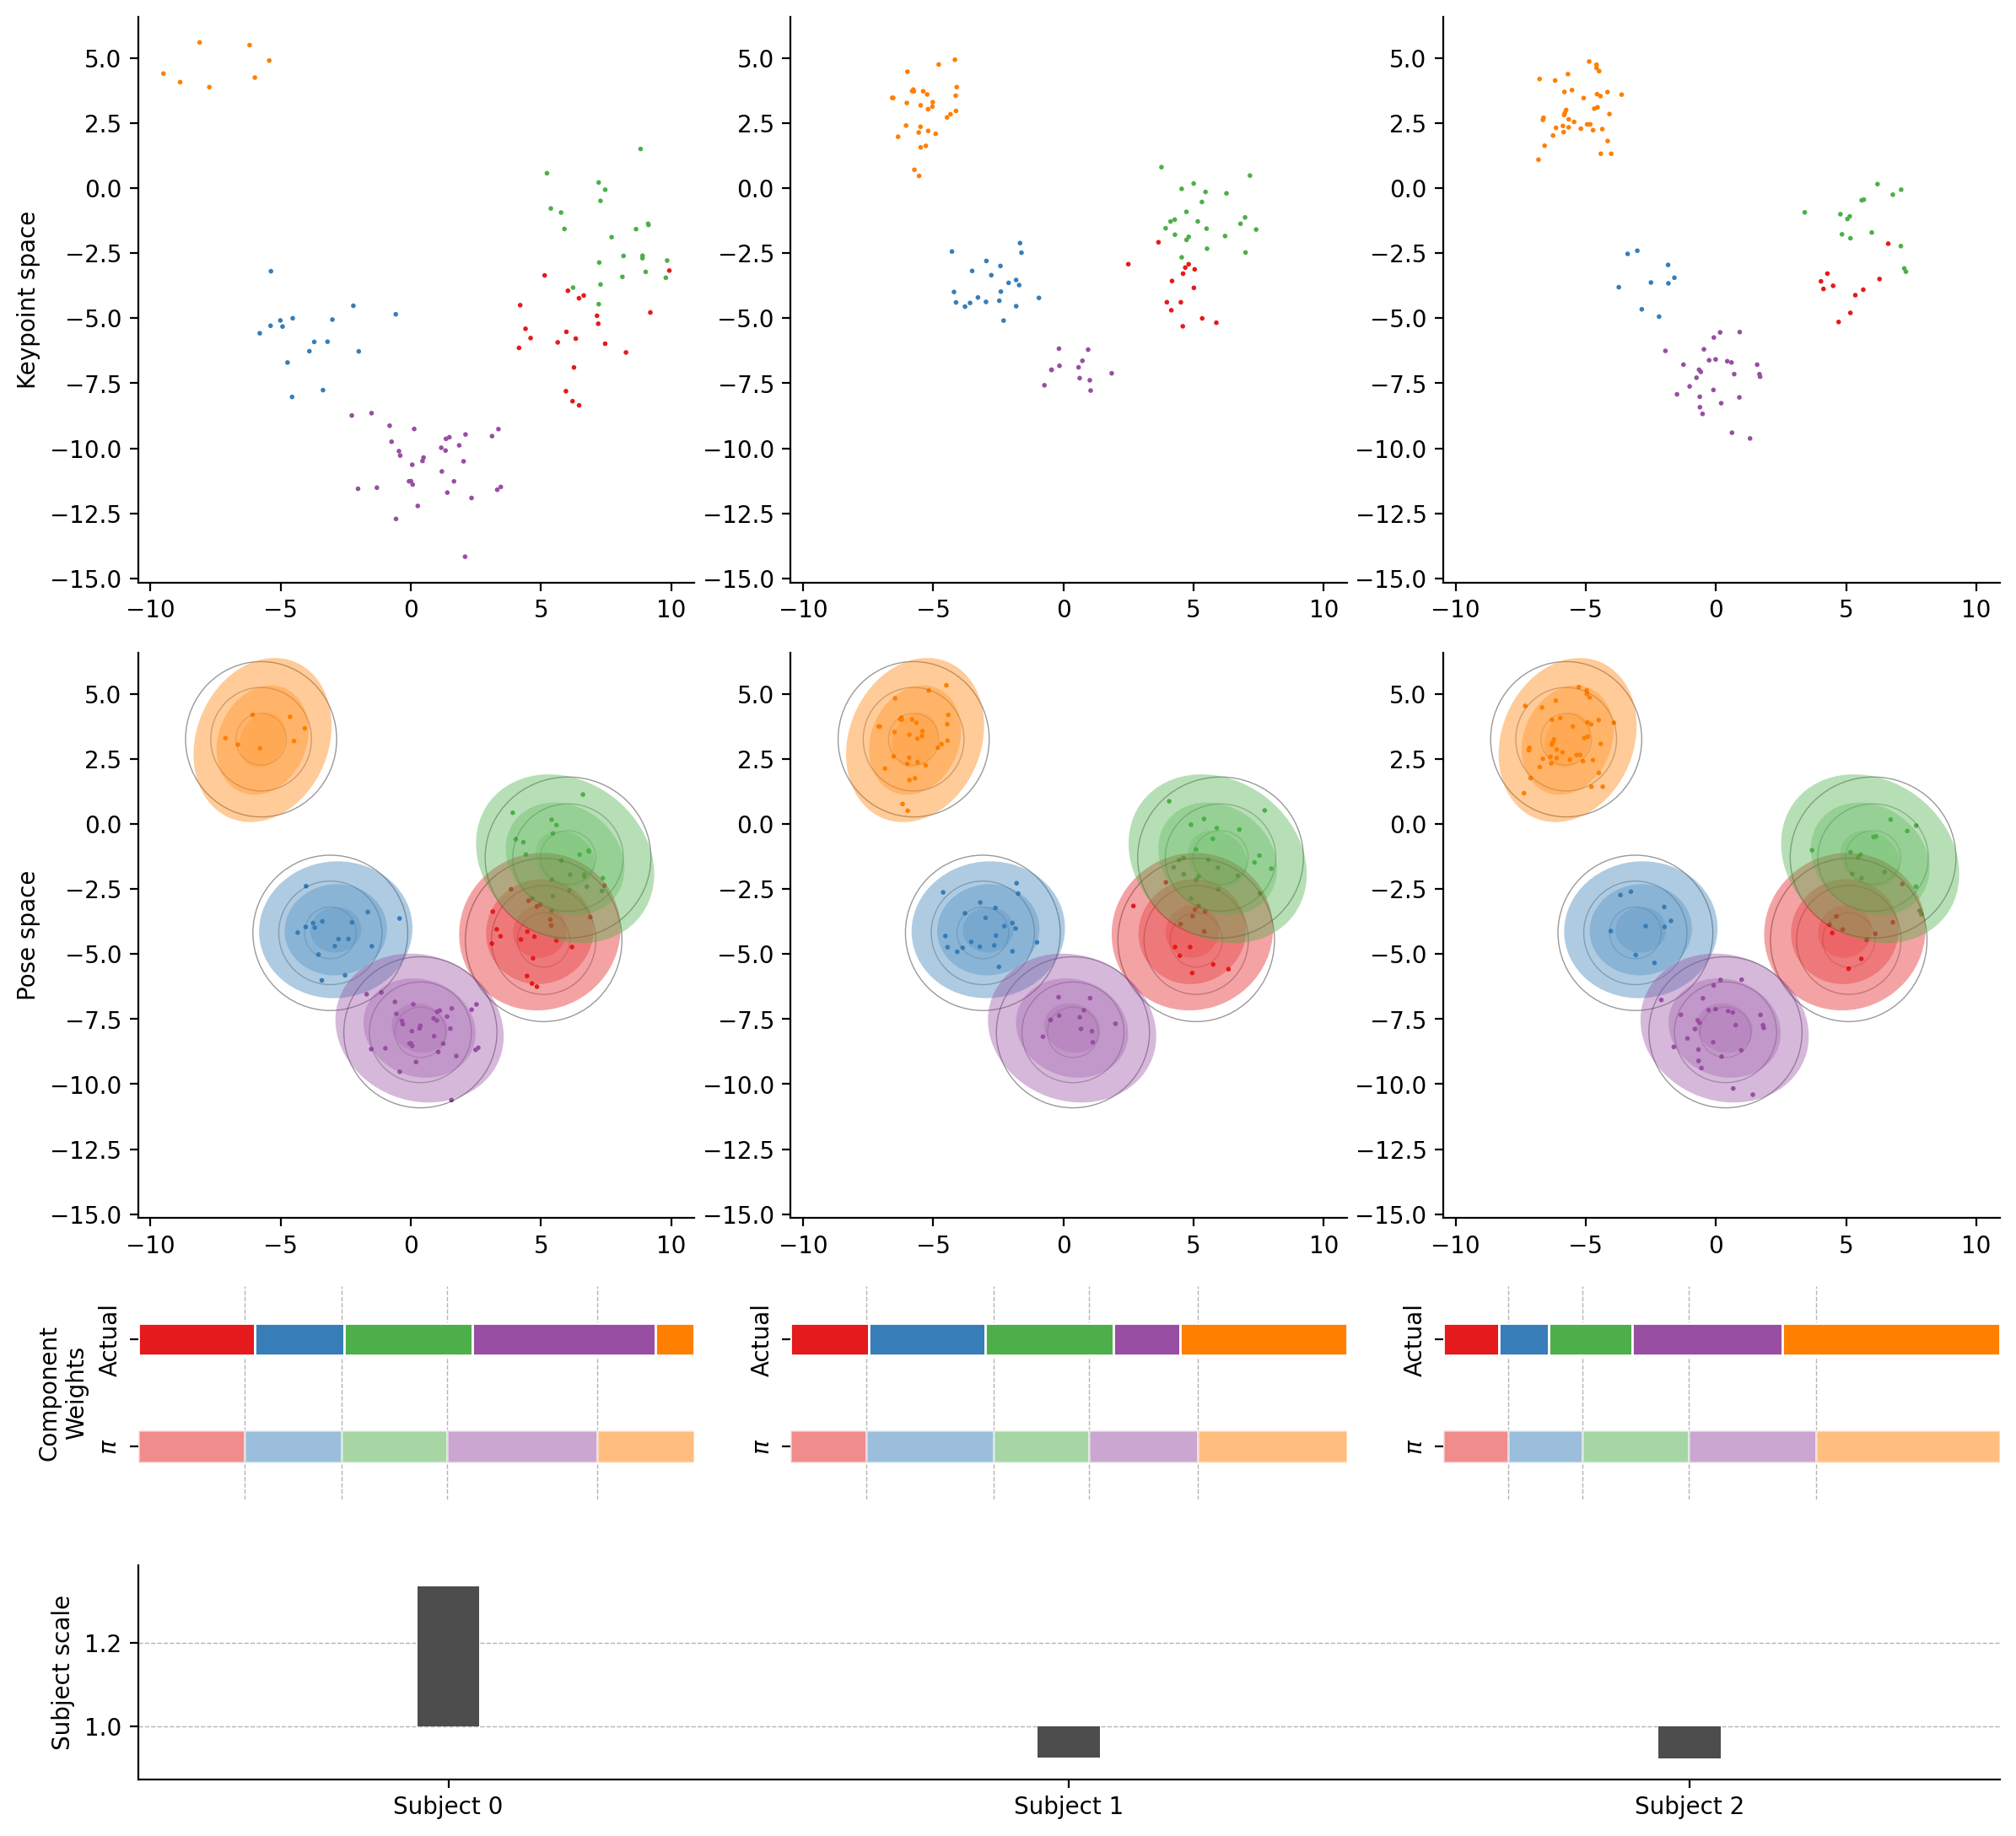

In [5]:
fig = plt.figure(figsize = (4 * pose_hyperparams.N, 8 + 1.5 + 1.5))
gs = gridspec.GridSpec(
    4, pose_hyperparams.N ,
    height_ratios = [4, 4, 1.5, 1.5])
ax = np.array([[
    fig.add_subplot(gs[r, c])
    for c in range(pose_hyperparams.N)]for r in range(3)])

comp_pal = np.array(sns.color_palette('Set1', n_colors = pose_hyperparams.L))

empirical_means, empirical_covs = fitting.gaussian_mle(util.computations.unstack(
    arr = gt_latents.poses,
    ixs = gt_latents.components,
    N = pose_hyperparams.L, axis = 0
))

for i_subj in range(pose_hyperparams.N):
    ax[0, i_subj].scatter(
        x = gt_obs.unstack(gt_obs.keypts)[i_subj][:, 0],
        y = gt_obs.unstack(gt_obs.keypts)[i_subj][:, 1],
        c = comp_pal[gt_obs.unstack(gt_latents.components)[i_subj]],
        s = 1,
    )
    sns.despine(ax=ax[0, i_subj])
    ax[0, i_subj].set_aspect(1.)
    if i_subj != 0:
        ax[0, i_subj].sharex(ax[0, 0])
        ax[0, i_subj].sharey(ax[0, 0])

    ax[1, i_subj].scatter(
        x = gt_obs.unstack(gt_latents.poses)[i_subj][:, 0],
        y = gt_obs.unstack(gt_latents.poses)[i_subj][:, 1],
        c = comp_pal[gt_obs.unstack(gt_latents.components)[i_subj]],
        s = 1,)
    sns.despine(ax=ax[1, i_subj])
    ax[1, i_subj].set_aspect(1.)
    ax[1, i_subj].sharex(ax[0, 0])
    ax[1, i_subj].sharey(ax[0, 0])


    vrng = mixtures.plot_cov_ellipses_comparison(
        gt_pose.means, gt_pose.covariances(),
        empirical_means, empirical_covs,
        pal = comp_pal, ax = ax[1, i_subj],
        alpha_range = (0.2, 0.4))

    empirical_latent_dist = jnp.histogram(
        gt_obs.unstack(gt_latents.components)[i_subj],
        jnp.arange(pose_hyperparams.L+1) - 0.5,
        density = True)[0]
    mixtures.compare_dirichlet_blocks(
        gt_pose.weights()[i_subj],
        [empirical_latent_dist],
        pal = comp_pal,
        ax = ax[2, i_subj],
        orientation = 'horizontal',
        labels = [r"$\pi$", 'Actual'],
        label_kwargs = dict(rotation = 90, verticalalignment = "center"))
    sns.despine(ax = ax[2, i_subj], bottom = True, left = True)

scale_ax = fig.add_subplot(gs[-1, :])
scales = jnp.exp(gt_morph.scale_log)
scale_ax.bar(
    np.arange(pose_hyperparams.N),
    jnp.maximum(scales - 1, 0) - jnp.minimum(scales - 1, 0),
    bottom = jnp.minimum(scales - 1, 0) + 1,
    color = '.3', zorder = 2, width = 0.1
)
scale_ax.set_xlim([-0.5, pose_hyperparams.N - 1 + 0.5])
scale_ax.set_ylim([scales.min() - 0.05, scales.max() + 0.05])
for tick in scale_ax.get_yticks()[1:-1]:
    scale_ax.axhline(tick, ls = '--', lw = 0.5, color = '.7', zorder = 1)

scale_ax.set_xticks(np.arange(pose_hyperparams.N))
scale_ax.set_xticklabels([f"Subject {i_subj}" for i_subj in range(pose_hyperparams.N)])
scale_ax.set_ylabel("Subject scale")
sns.despine(ax = scale_ax)

ax[0, 0].set_ylabel("Keypoint space")
ax[1, 0].set_ylabel("Pose space")
ax[2, 0].set_ylabel("Component\nWeights")
fig.tight_layout()
plt.show()

### Single M-step

In [34]:
aux_pdf, term_weights = em.estep(
    model = model,
    observations = gt_obs,
    estimated_params = joint_model.JointParameters(posespace = gt_pose, morph = gt_morph),
    hyperparams = hyperparams
    )

In [7]:
loss_hist, fit_params = em.mstep(
    model = model,
    # init_params = smgmm_test.pertub_parameters(jr.PRNGKey(1), smgmm_data.params, 0.0),
    # estimated_params = smgmm_test.pertub_parameters(jr.PRNGKey(0), smgmm_data.params, 0.0),
    init_params = joint_model.JointParameters(posespace = gt_pose, morph = gt_morph),
    aux_pdf = aux_pdf,
    term_weights = term_weights,
    emissions = gt_obs,
    hyperparams = hyperparams,
    optimizer = optax.adam(learning_rate=5e-4),
    n_steps = 2000,
    log_every = -1,
    progress = False
)

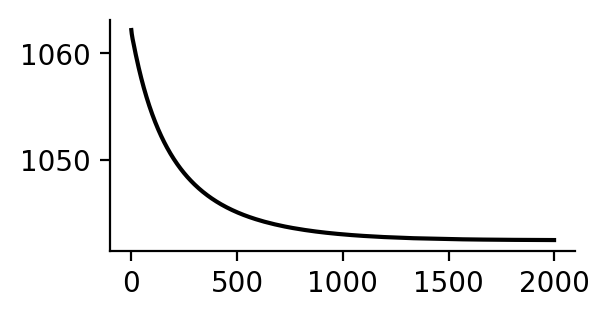

In [8]:
plt.figure(figsize = (3, 1.5))
plt.plot(loss_hist, 'k-')
sns.despine()

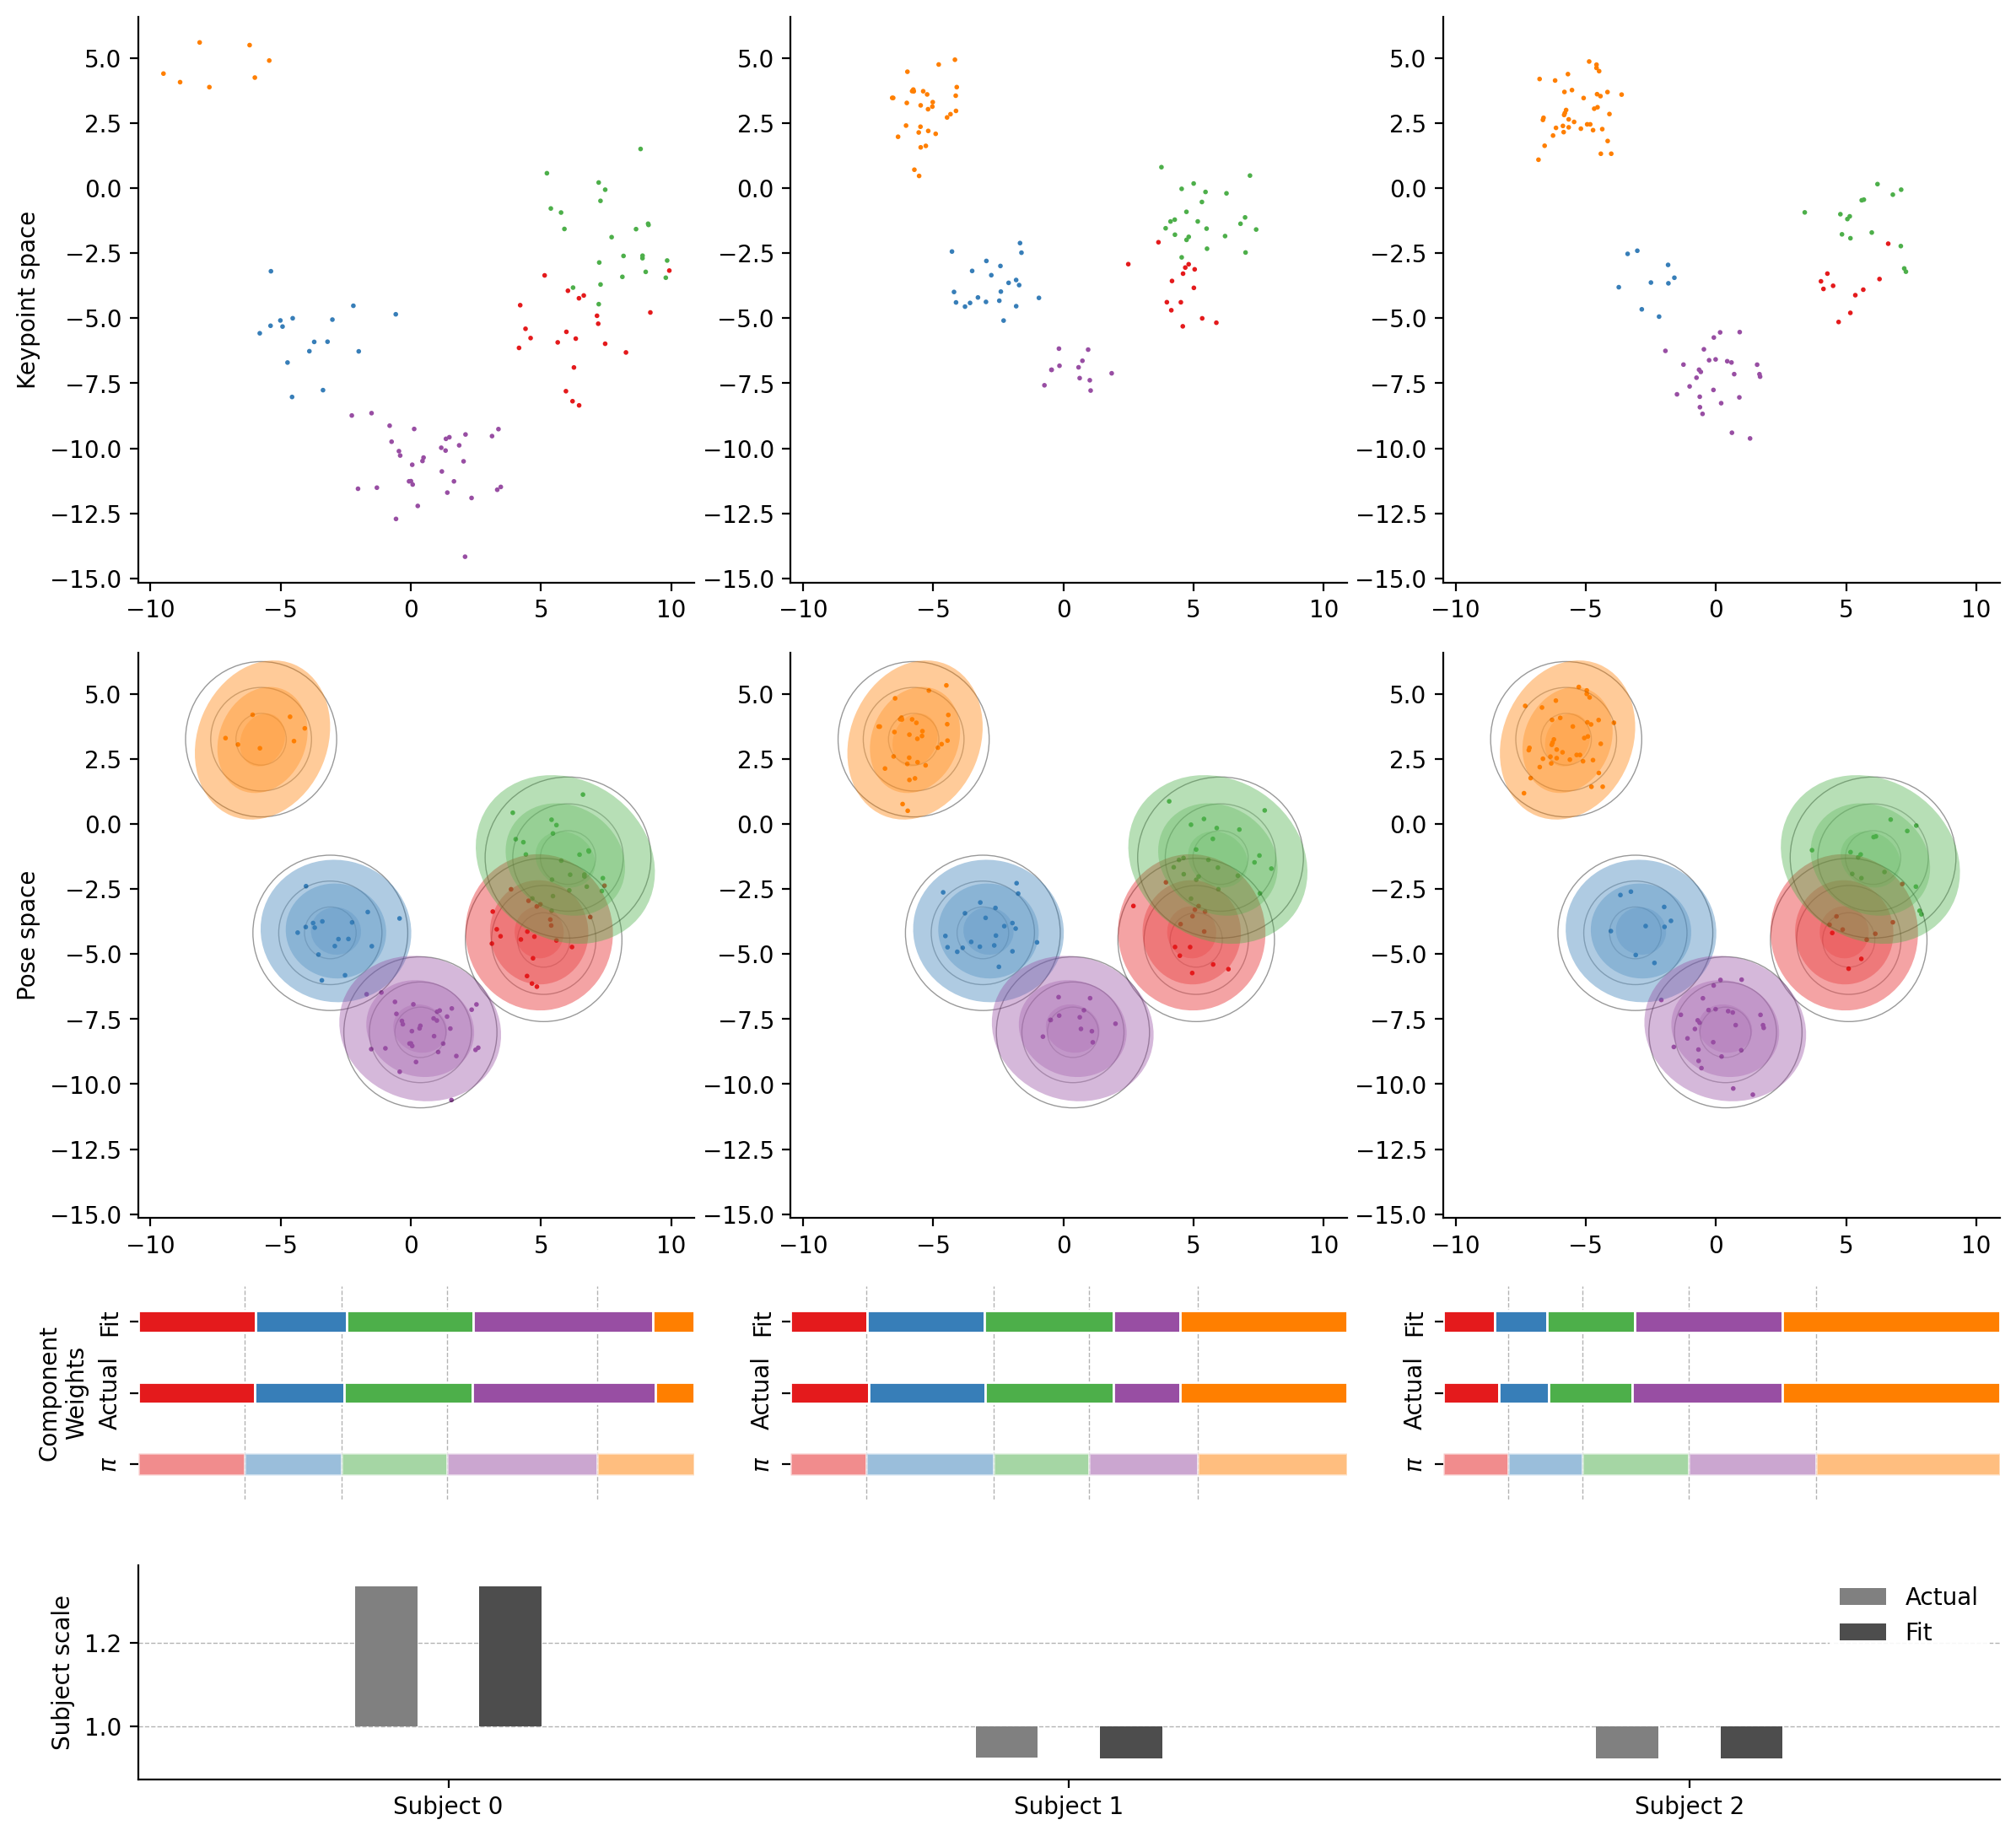

In [9]:
fig = plt.figure(figsize = (4 * pose_hyperparams.N, 8 + 1.5 + 1.5))
gs = gridspec.GridSpec(
    4, pose_hyperparams.N ,
    height_ratios = [4, 4, 1.5, 1.5])
ax = np.array([[
    fig.add_subplot(gs[r, c])
    for c in range(pose_hyperparams.N)]for r in range(3)])

comp_pal = np.array(sns.color_palette('Set1', n_colors = pose_hyperparams.L))

for i_subj in range(pose_hyperparams.N):
    ax[0, i_subj].scatter(
        x = gt_obs.unstack(gt_obs.keypts)[i_subj][:, 0],
        y = gt_obs.unstack(gt_obs.keypts)[i_subj][:, 1],
        c = comp_pal[gt_obs.unstack(gt_latents.components)[i_subj]],
        s = 1,
    )
    sns.despine(ax=ax[0, i_subj])
    ax[0, i_subj].set_aspect(1.)
    if i_subj != 0:
        ax[0, i_subj].sharex(ax[0, 0])
        ax[0, i_subj].sharey(ax[0, 0])

    ax[1, i_subj].scatter(
        x = gt_obs.unstack(gt_latents.poses)[i_subj][:, 0],
        y = gt_obs.unstack(gt_latents.poses)[i_subj][:, 1],
        c = comp_pal[gt_obs.unstack(gt_latents.components)[i_subj]],
        s = 1,)
    sns.despine(ax=ax[1, i_subj])
    ax[1, i_subj].set_aspect(1.)
    ax[1, i_subj].sharex(ax[0, 0])
    ax[1, i_subj].sharey(ax[0, 0])

    vrng = mixtures.plot_cov_ellipses_comparison(
        gt_pose.means, gt_pose.covariances(),
        fit_params.posespace.means, fit_params.posespace.covariances(),
        pal = comp_pal, ax = ax[1, i_subj],
        alpha_range = (0.2, 0.4))

    empirical_latent_dist = jnp.histogram(
        gt_obs.unstack(gt_latents.components)[i_subj],
        jnp.arange(pose_hyperparams.L+1) - 0.5,
        density = True)[0]
    mixtures.compare_dirichlet_blocks(
        gt_pose.weights()[i_subj],
        [empirical_latent_dist, fit_params.posespace.weights()[i_subj]],
        pal = comp_pal,
        ax = ax[2, i_subj],
        orientation = 'horizontal',
        labels = [r"$\pi$", 'Actual', 'Fit'],
        label_kwargs = dict(rotation = 90, verticalalignment = "center"))
    sns.despine(ax = ax[2, i_subj], bottom = True, left = True)

scale_ax = fig.add_subplot(gs[-1, :])
scales = jnp.exp(gt_morph.scale_log)
scale_ax.bar(
    np.arange(pose_hyperparams.N) - 0.1,
    jnp.maximum(scales - 1, 0) - jnp.minimum(scales - 1, 0),
    bottom = jnp.minimum(scales - 1, 0) + 1,
    color = '.5', zorder = 2, width = 0.1,
    label = 'Actual'
)
scales_fit = jnp.exp(fit_params.morph.scale_log)
scale_ax.bar(
    np.arange(pose_hyperparams.N) + 0.1,
    jnp.maximum(scales_fit - 1, 0) - jnp.minimum(scales_fit - 1, 0),
    bottom = jnp.minimum(scales_fit - 1, 0) + 1,
    color = '.3', zorder = 2, width = 0.1,
    label = 'Fit'
)
scale_ax.set_xlim([-0.5, pose_hyperparams.N - 1 + 0.5])
scale_ax.set_ylim([scales.min() - 0.05, scales.max() + 0.05])
for tick in scale_ax.get_yticks()[1:-1]:
    scale_ax.axhline(tick, ls = '--', lw = 0.5, color = '.7', zorder = 1)
scale_ax.legend(loc = "upper right", fancybox = False, edgecolor = 'w', framealpha = 0.9)

scale_ax.set_xticks(np.arange(pose_hyperparams.N))
scale_ax.set_xticklabels([f"Subject {i_subj}" for i_subj in range(pose_hyperparams.N)])
scale_ax.set_ylabel("Subject scale")
sns.despine(ax = scale_ax)

ax[0, 0].set_ylabel("Keypoint space")
ax[1, 0].set_ylabel("Pose space")
ax[2, 0].set_ylabel("Component\nWeights")
fig.tight_layout()
plt.show()

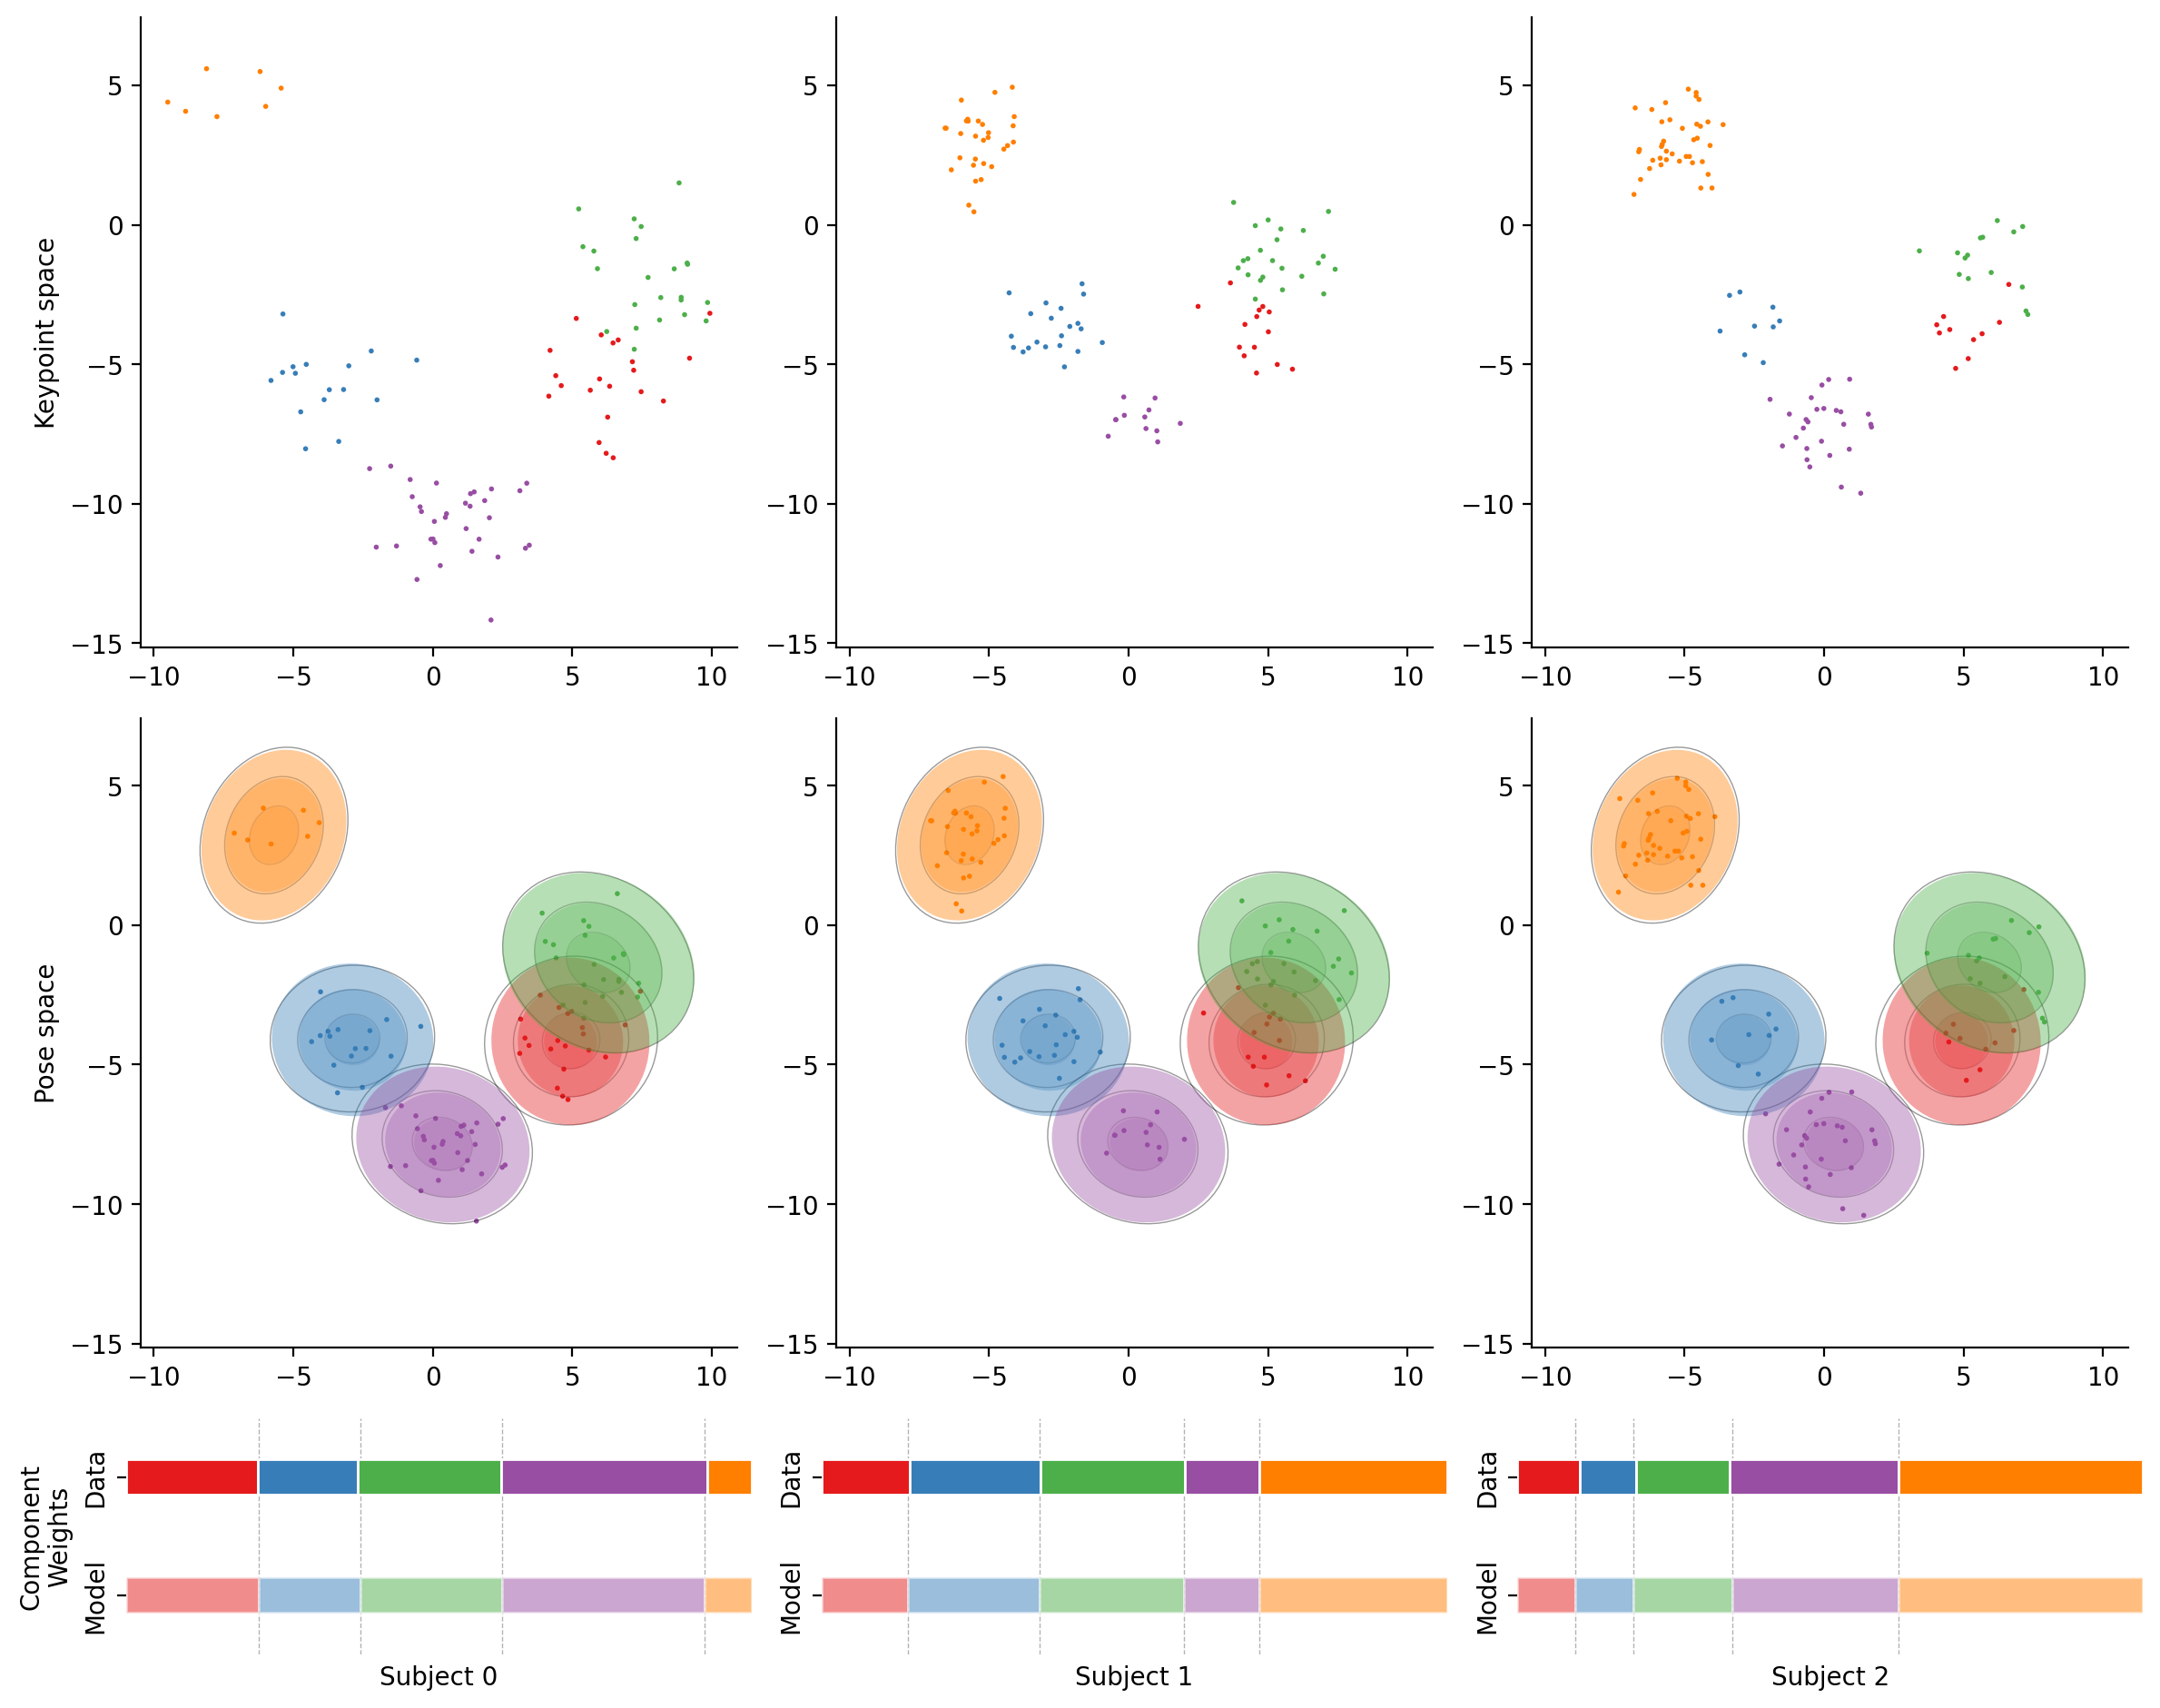

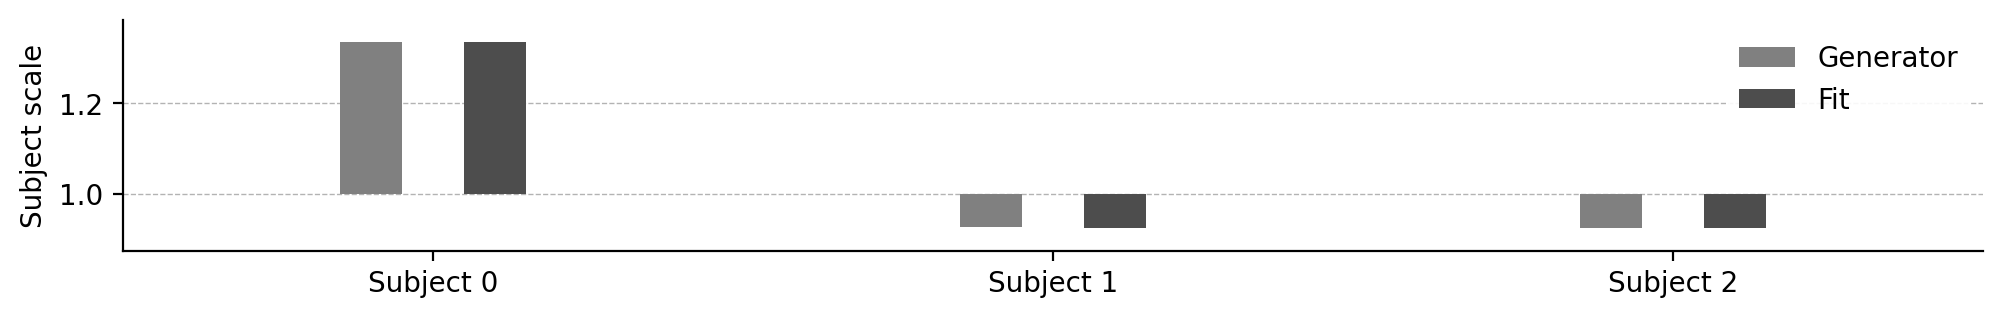

In [10]:
fig = plt.figure(figsize = (4 * pose_hyperparams.N, 8 + 1.5 + 1.5))
ax = mixtures.sampled_mixture_plot(fig, pose_hyperparams, fit_params.posespace, gt_latents, gt_obs)
plt.show()

fig = plt.figure(figsize = (4 * pose_hyperparams.N, 1.5))
viz_morphs.plot_subjectwise_scalar_comparison(
    fig.gca(),
    jnp.exp(jnp.stack([gt_morph.scale_log, fit_params.morph.scale_log], axis = 1)),
    ["Generator", "Fit"],)


### Debugging

In [46]:
from kpsn.util.computations import gaussian_product
from tensorflow_probability.substrates import jax as tfp

In [139]:

T, N = 7, 5
a = np.random.randn(T, 1); b = np.random.randn(N, 1)
A = 0.5 * abs(np.random.randn(T, 1, 1)); B = 0.5 * abs(np.random.randn(N, 1, 1))

K, c, C, gp_norm = gaussian_product(
    a[:, None], A[:, None], b[None, :], B[None, :],
    return_normalizer = True)

Reloading 'kpsn.util.computations'.
Reloading 'kpsn.models.pose.gmm'.


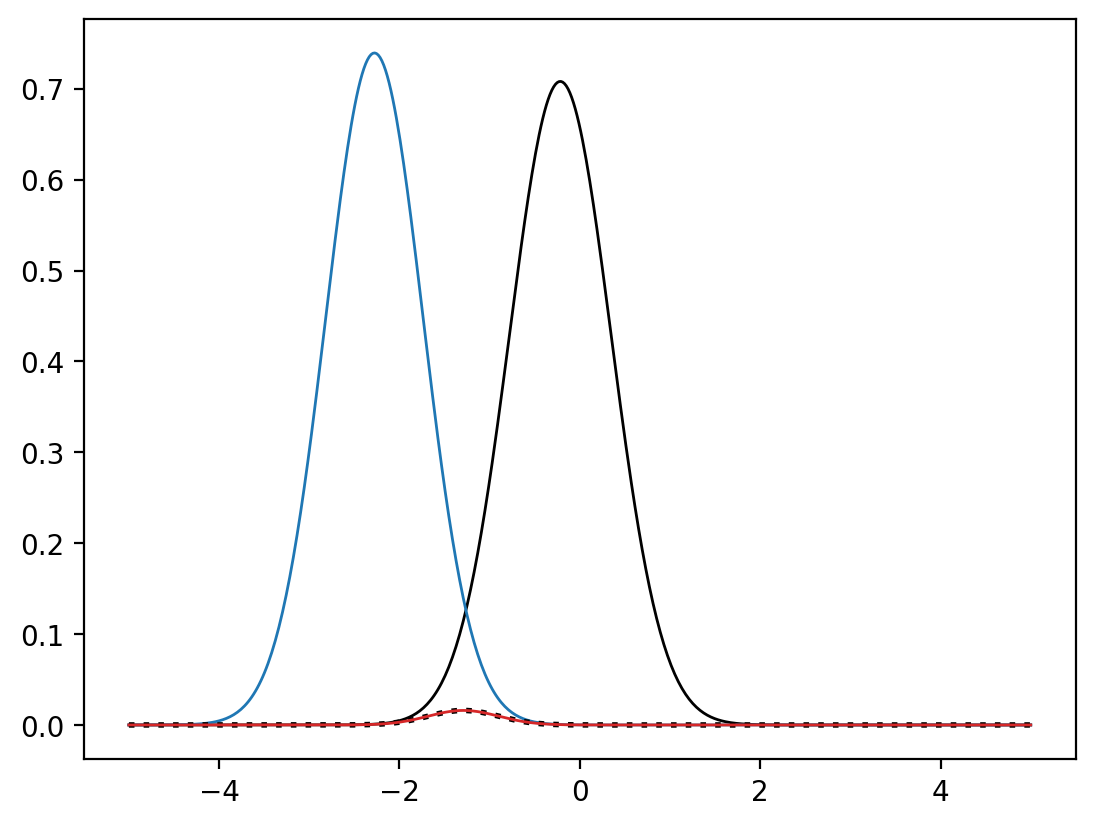

In [142]:
t = 2; z = 2
plot_lim = 5
query_x = np.linspace(-plot_lim, plot_lim, 500)

obs_color = 'k'
est_color = 'C0'
cbn_color = 'C3'

obs_dist = tfp.distributions.Normal(loc = a[t, 0], scale = np.sqrt(A[t, 0, 0])).prob(query_x)
est_dist = tfp.distributions.Normal(loc = b[z, 0], scale = np.sqrt(B[z, 0, 0])).prob(query_x)
cbn_dist = tfp.distributions.Normal(loc = c[t, z, 0], scale = np.sqrt(C[t, z, 0, 0])).prob(query_x)

fig, ax = plt.subplots()
plt.plot(query_x, obs_dist, '-', lw = 1, color = obs_color)
plt.plot(query_x, est_dist, '-', lw = 1, color = est_color)
plt.plot(query_x, obs_dist * est_dist, ':', lw = 2, color = obs_color)
plt.plot(query_x, K[t, z] * gp_norm[t, z] * cbn_dist, '-', lw = 1, color = cbn_color)

plt.show()

##### Next

`quadform` appears to compute the right thing - next, look at the objects going into `quadform` during `gmm.aux_dist` to see if we do what we think they're doing.
- Refactor out the inverted-linear normal and numerically confirm

$$
N(y; Ax, R) = \frac{Z_R}{Z_{A^{-1}R{A^{-1}}^T}} N(x; A^{-1}y, A^{-1}R{A^{-1}}^T)
$$

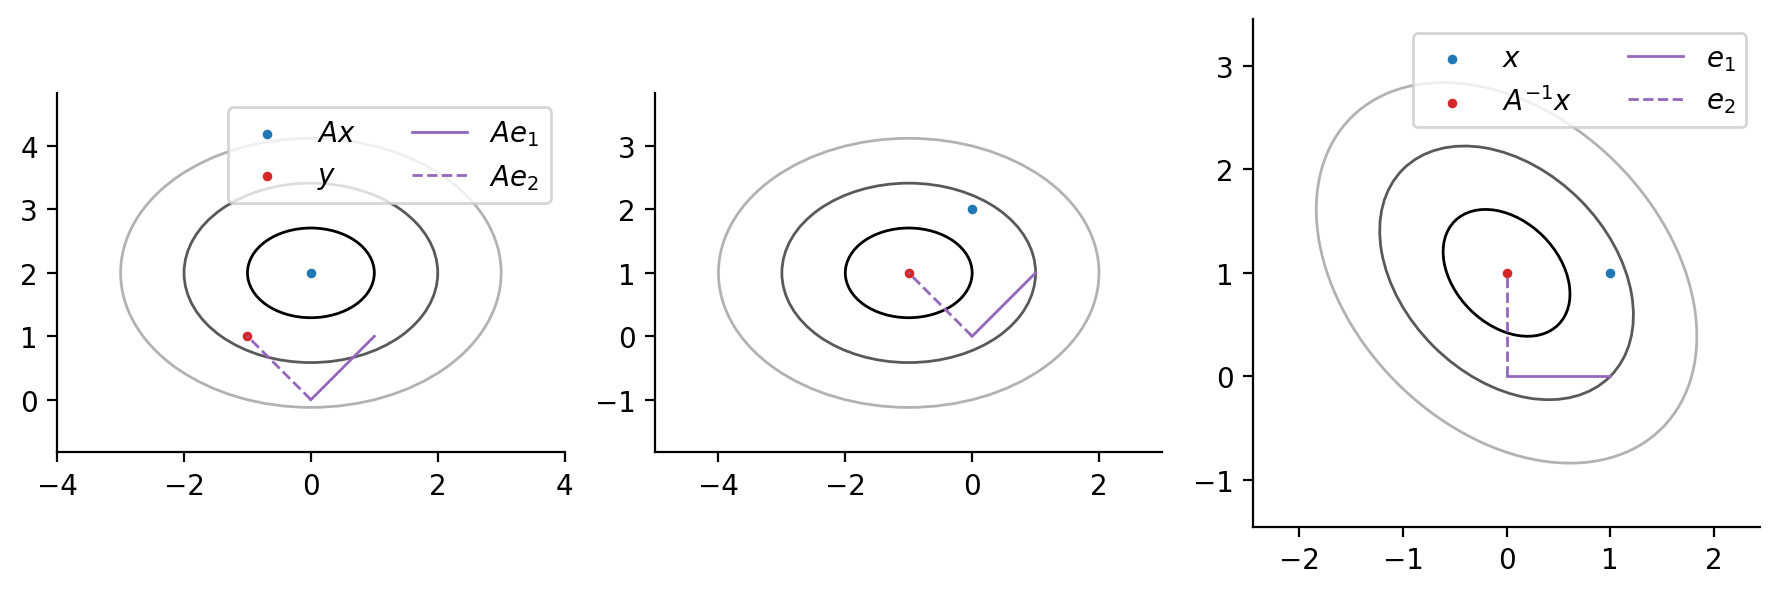

In [109]:
x = np.array([1., 1])
A = np.array([[1., -1], [1, 1]])
cov = np.array([[1., 0], [0, 0.5]])
y = np.array([-1., 1])

new_mean, new_cov, normalizer = util.computations.linear_transform_gaussian(
    y, cov, A, return_normalizer = True)

transformed_mean = (A @ x[:, None])[..., 0]
transformed_e = (A @ np.eye(2))

fig, ax = plt.subplots(1, 3, figsize = (9, 3))

# keypoint space distribution around Ax
_, vrng1 = mixtures.fading_cov_ellipses(
    transformed_mean, cov,
    ec = 'k', ax = ax[0])
ax[0].scatter(transformed_mean[0, None], transformed_mean[1, None], c = 'C0', s = 6, label = r"$Ax$")
ax[0].scatter(y[0, None], y[1, None], c = 'C3', s = 6, label = r"$y$")
ax[0].plot([0, transformed_e[0, 0]], [0, transformed_e[1, 0]], '-', color = 'C4', lw = 1, label = r"$Ae_1$")
ax[0].plot([0, transformed_e[0, 1]], [0, transformed_e[1, 1]], '--', color = 'C4', lw = 1, label = r"$Ae_2$")

# keypoint space distribution around y
_, vrng3 = mixtures.fading_cov_ellipses(
    y, cov,
    ec = 'k', ax = ax[1])
ax[1].scatter(transformed_mean[0, None], transformed_mean[1, None], c = 'C0', s = 6)
ax[1].scatter(y[0, None], y[1, None], c = 'C3', s = 6)
ax[1].plot([0, transformed_e[0, 0]], [0, transformed_e[1, 0]], '-', color = 'C4', lw = 1)
ax[1].plot([0, transformed_e[0, 1]], [0, transformed_e[1, 1]], '--', color = 'C4', lw = 1)

# pose space distribution around y
_, vrng2 = mixtures.fading_cov_ellipses(
    new_mean, new_cov,
    ec = 'k', ax = ax[2])
ax[2].scatter(x[0, None], x[1, None], c = 'C0', s = 6, label = r"$x$")
ax[2].scatter(new_mean[0, None], new_mean[1, None], c = 'C3', s = 6, label = r"$A^{-1}x$")
ax[2].plot([0, 1], [0, 0], '-', color = 'C4', lw = 1, label = r"$e_1$")
ax[2].plot([0, 0], [0, 1], '--', color = 'C4', lw = 1, label = r"$e_2$")


ax[0].legend(loc = 'upper right', ncols = 2)
ax[2].legend(loc = 'upper right', ncols = 2)
mixtures.apply_vrng(ax[0], vrng1)
mixtures.apply_vrng(ax[1], vrng3)
mixtures.apply_vrng(ax[2], vrng2)
sns.despine(ax=ax[0])
sns.despine(ax=ax[1])
sns.despine(ax=ax[2])
plt.tight_layout()
plt.show()

In [132]:
x = np.array([1., 1, 1.])
A = np.array([[1., -1, 0], [1, 1, 1], [0, 0, 1]])
cov = np.array([[1., 0, 0], [0, 0.5, 0], [0, 0, 1.]])
y = np.array([-1., 1, 1.])

transformed_mean = (A @ x[:, None])[..., 0]
new_mean, new_cov, normalizer = util.computations.linear_transform_gaussian(y, cov, A, return_normalizer = True)


print(new_mean.shape, new_cov.shape)
kpspace_prob = tfp.distributions.MultivariateNormalFullCovariance(
    loc = transformed_mean, covariance_matrix = cov).prob(y)
pospace_prob = normalizer * tfp.distributions.MultivariateNormalFullCovariance(
    loc = new_mean, covariance_matrix = new_cov).prob(x)

norm_cov = (2 * jnp.pi) ** (3/2) * jnp.linalg.det(cov) ** 0.5
norm_new_cov = (2 * jnp.pi) ** (3/2) * jnp.linalg.det(new_cov) ** 0.5

print(kpspace_prob, pospace_prob)
print(
    util.computations.exp_mahalanobis(y, transformed_mean, cov) /
        (norm_cov),
    util.computations.exp_mahalanobis(x, new_mean, new_cov) / 
        (norm_new_cov))
print(normalizer, norm_new_cov / norm_cov)


Reloading 'kpsn.util.computations'.
(3,) (3, 3)
0.0009975168 0.0009975168
0.0009975163 0.0019950327
0.5 0.5


In [129]:
jnp.linalg.det(A)

Array(10., dtype=float32)

### Initialization

In [15]:
init_morph_params = scalar.init(
    morph_hyperparams,
    gt_obs,
    reference_subject = 0
    )
init_pose_params = gmm.init_parameters_and_latents(
    pose_hyperparams,
    gt_obs,
    reference_subject = 0
)
init_params = joint_model.JointParameters(posespace = init_pose_params, morph = init_morph_params)

Reloading 'kpsn.models.joint_model'.
Reloading 'kpsn.models.morph.morph_model'.


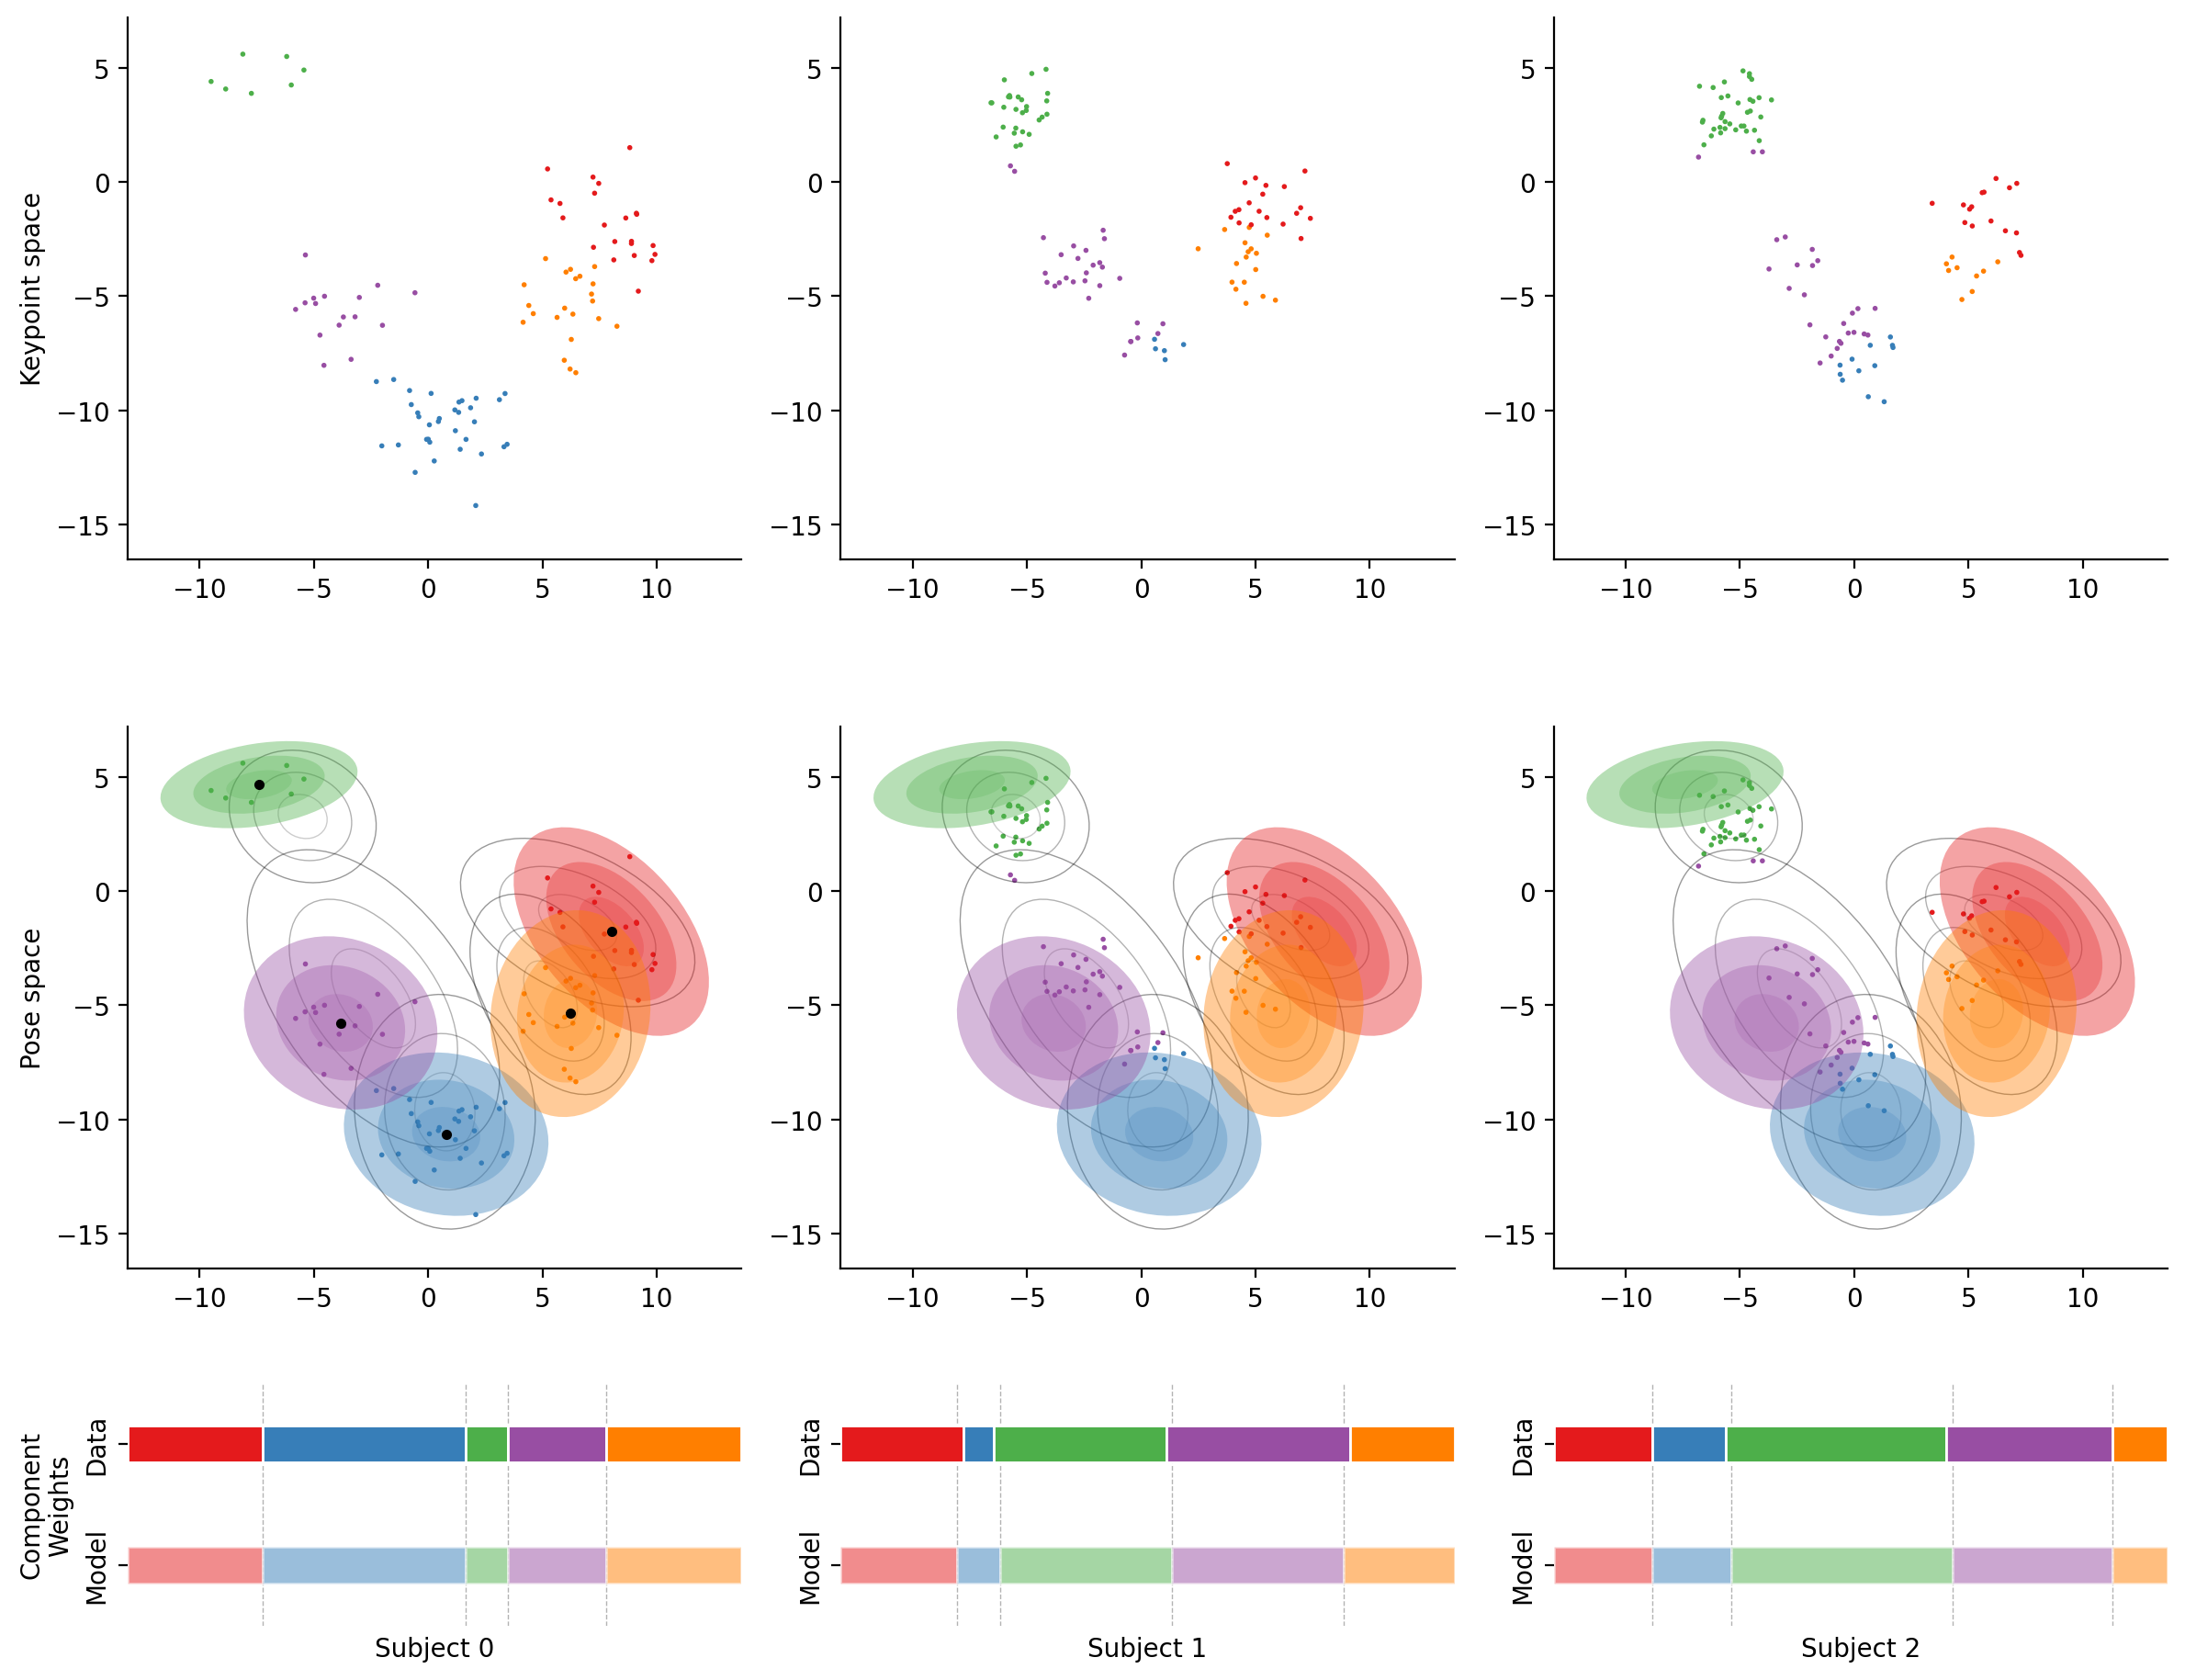

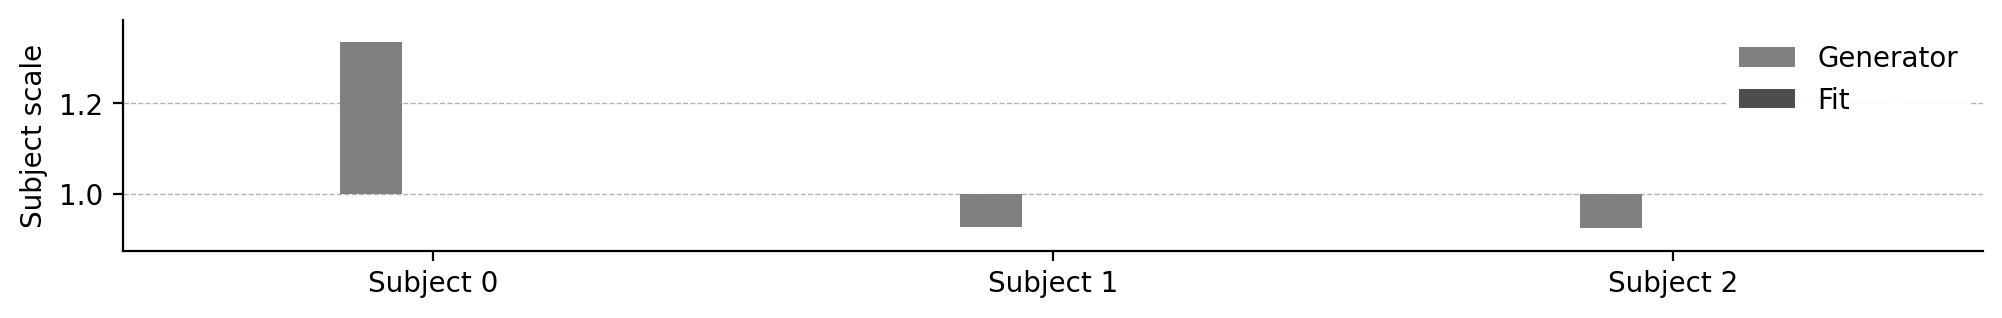

In [27]:
fig = plt.figure(figsize = (4 * pose_hyperparams.N, 8 + 1.5 + 1.5))
est_states = joint_model.latent_mle(model, gt_obs, init_params, hyperparams)
ax = mixtures.sampled_mixture_plot(fig, pose_hyperparams, init_pose_params, est_states, gt_obs)
plt.show()

fig = plt.figure(figsize = (4 * pose_hyperparams.N, 1.5))
viz_morphs.plot_subjectwise_scalar_comparison(
    fig.gca(),
    jnp.exp(jnp.stack([gt_morph.scale_log, init_morph_params.scale_log], axis = 1)),
    ["Generator", "Fit"],)

### M-Step using initialzed parameters

In [38]:
aux_pdf, term_weights = em.estep(
    model = model,
    observations = gt_obs,
    estimated_params = init_params,
    hyperparams = hyperparams
    )
loss_hist, fit_params = em.mstep(
    model = model,
    init_params = init_params,
    aux_pdf = aux_pdf,
    term_weights = term_weights,
    emissions = gt_obs,
    hyperparams = hyperparams,
    optimizer = optax.adam(learning_rate=5e-3),
    n_steps = 2000,
    log_every = -1,
    progress = False
)

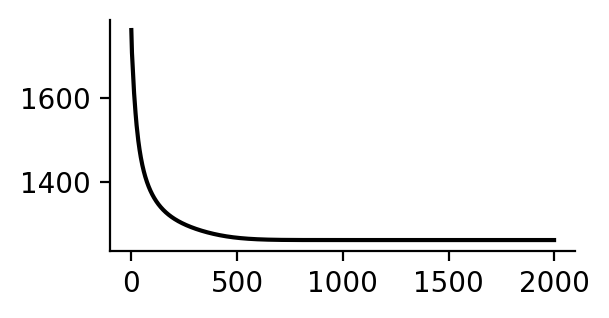

In [39]:
plt.figure(figsize = (3, 1.5))
plt.plot(loss_hist, 'k-')
sns.despine()

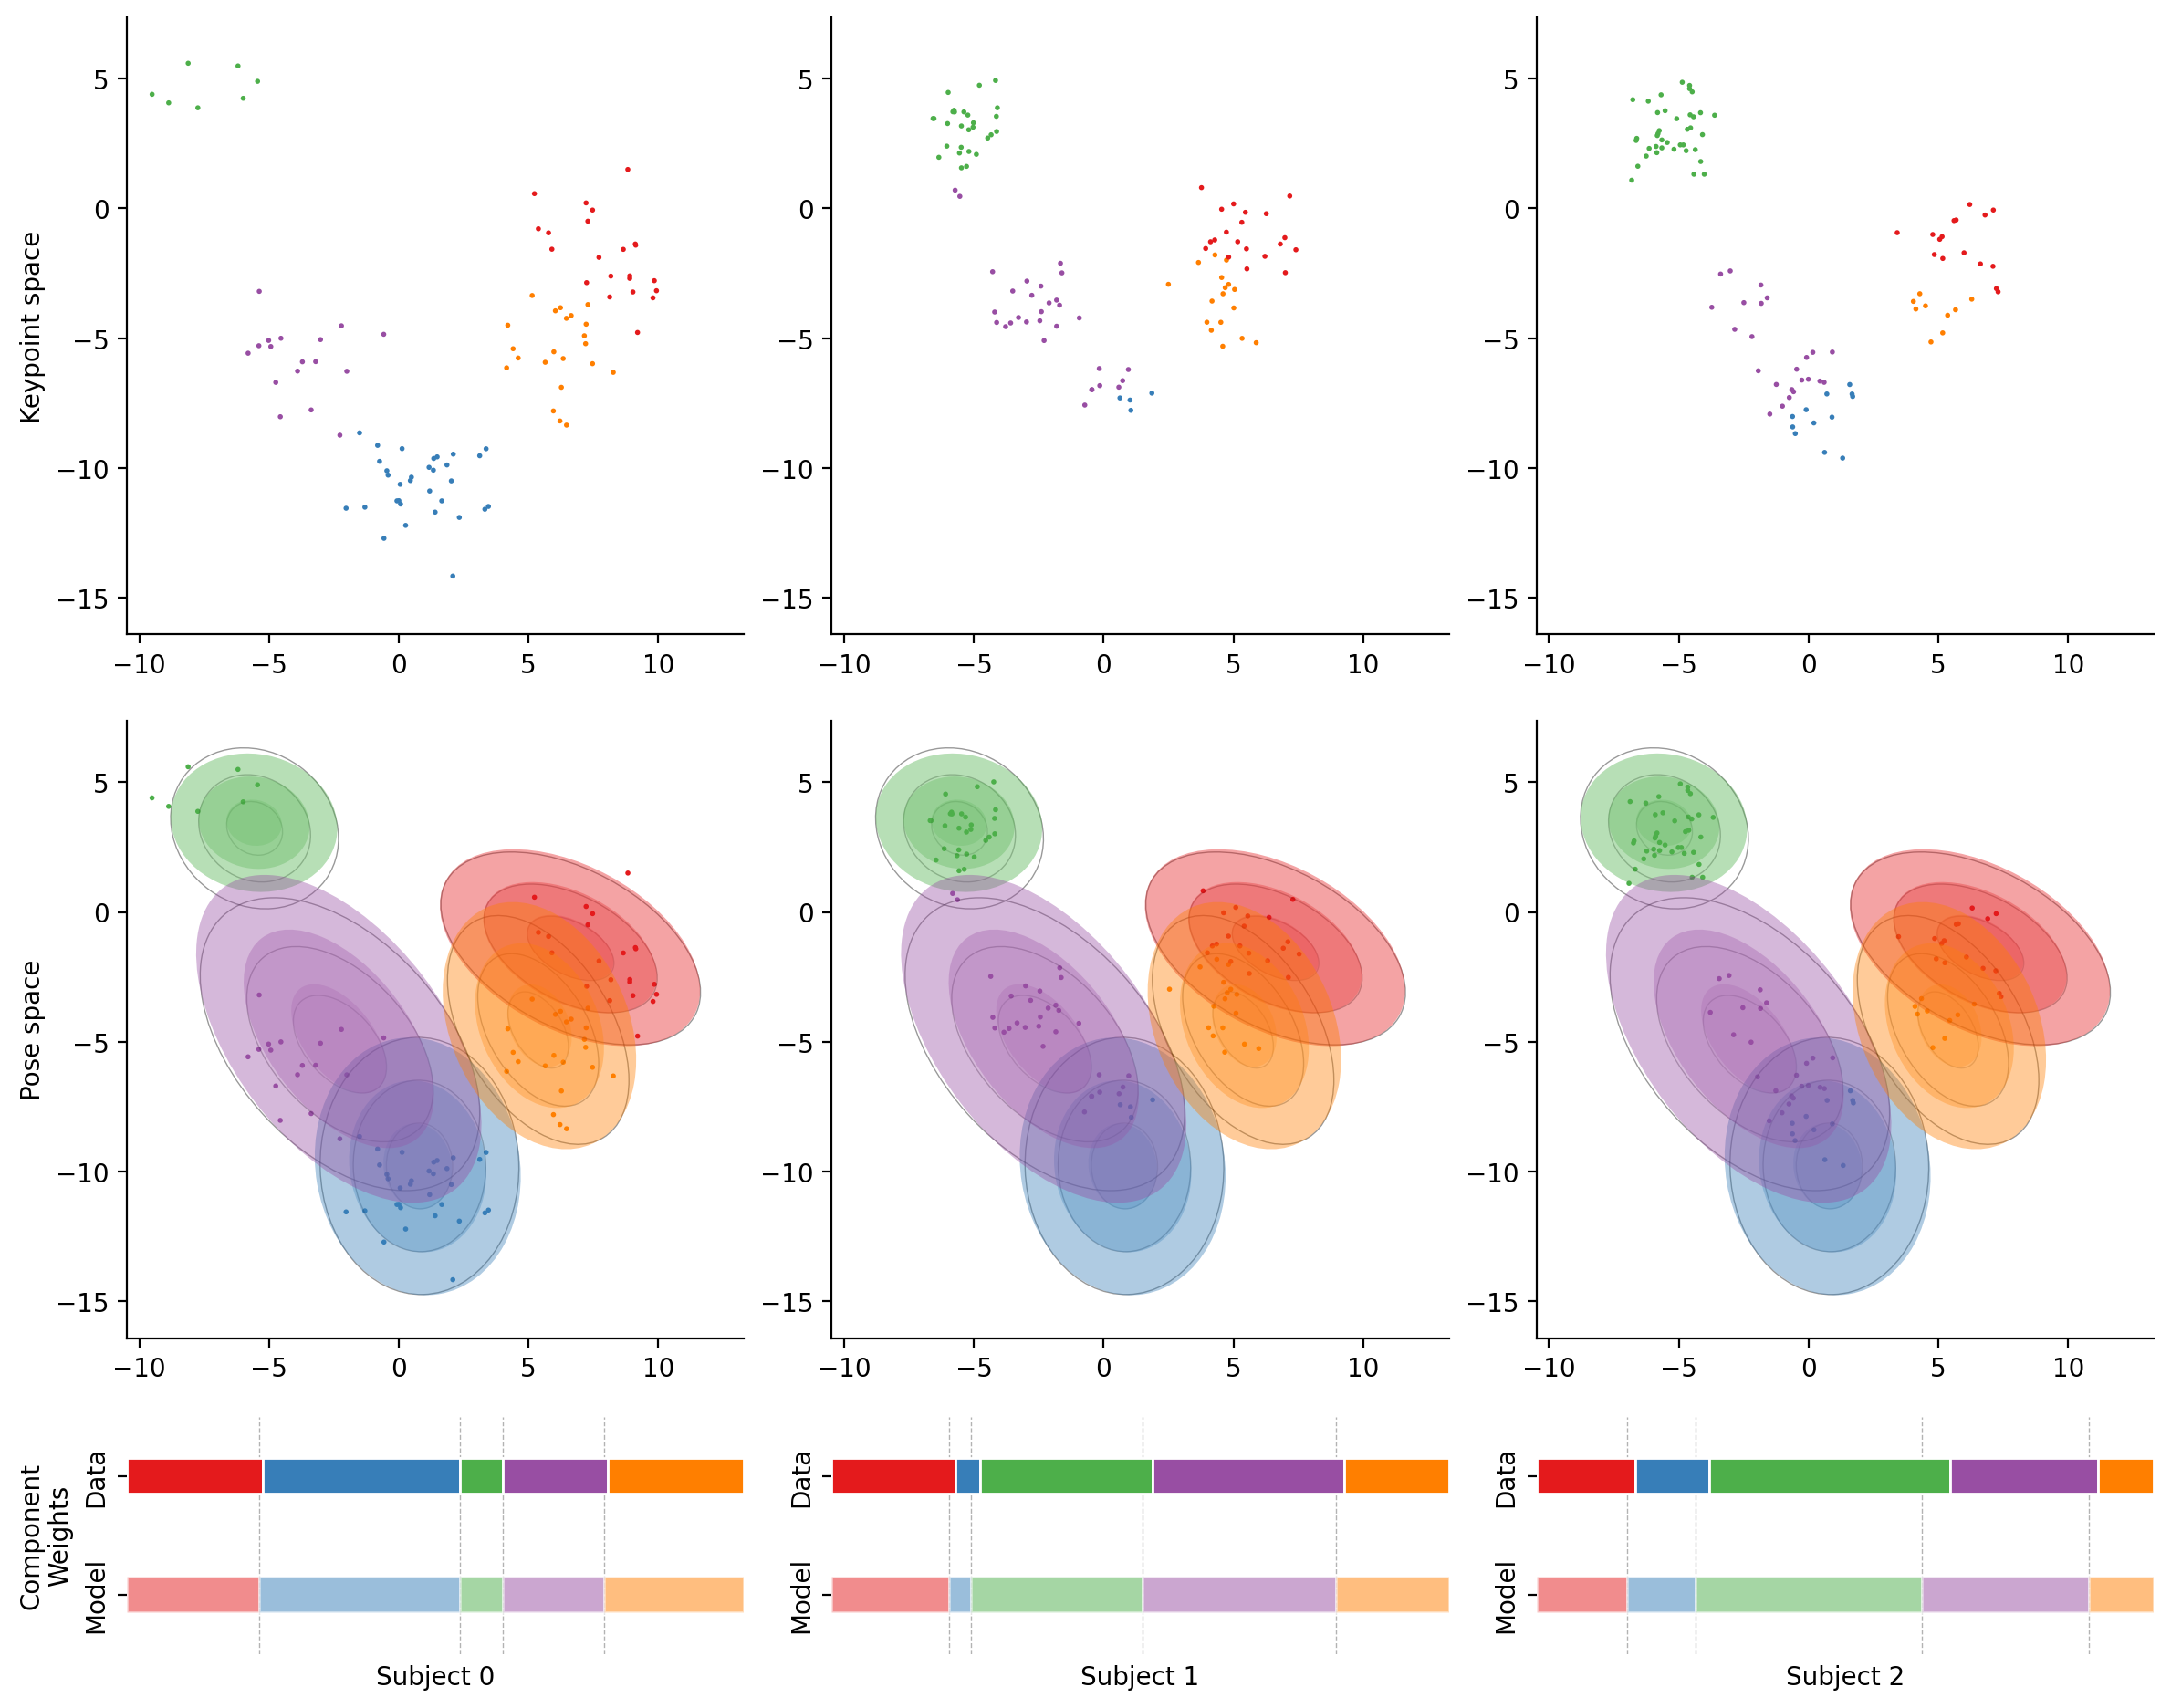

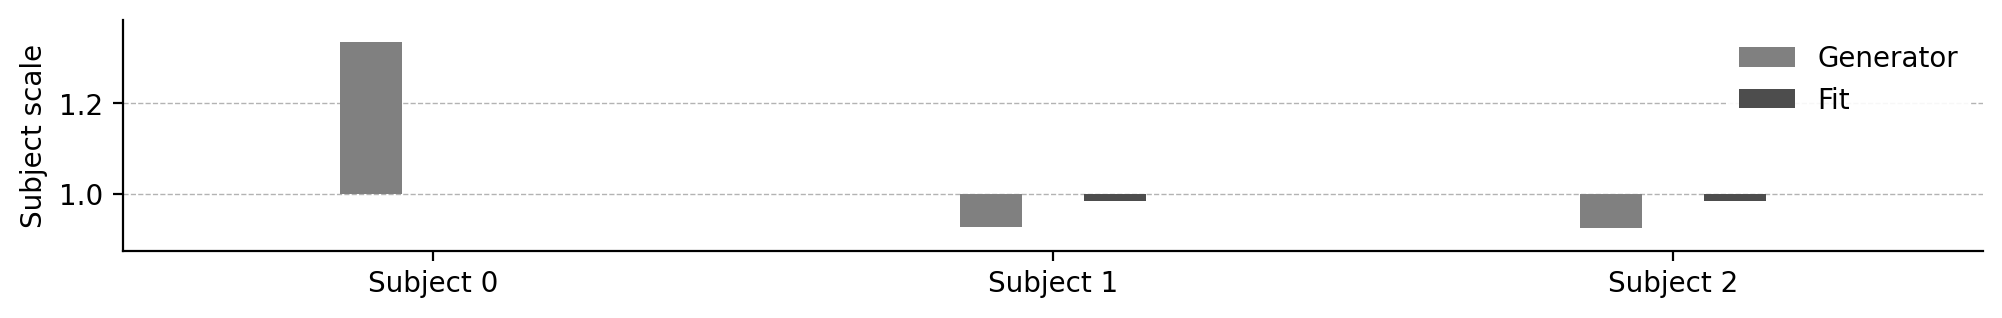

In [40]:
fig = plt.figure(figsize = (4 * pose_hyperparams.N, 8 + 1.5 + 1.5))
est_states = joint_model.latent_mle(model, gt_obs, fit_params, hyperparams)
ax = mixtures.sampled_mixture_plot(fig, pose_hyperparams, fit_params.posespace, est_states, gt_obs)
plt.show()

fig = plt.figure(figsize = (4 * pose_hyperparams.N, 1.5))
viz_morphs.plot_subjectwise_scalar_comparison(
    fig.gca(),
    jnp.exp(jnp.stack([gt_morph.scale_log, fit_params.morph.scale_log], axis = 1)),
    ["Generator", "Fit"],)

### M-Step using results of previous

In [41]:
aux_pdf, term_weights = em.estep(
    model = model,
    observations = gt_obs,
    estimated_params = fit_params,
    hyperparams = hyperparams
    )
loss_hist_step2, fit_params_step2 = em.mstep(
    model = model,
    init_params = fit_params,
    aux_pdf = aux_pdf,
    term_weights = term_weights,
    emissions = gt_obs,
    hyperparams = hyperparams,
    optimizer = optax.adam(learning_rate=5e-3),
    n_steps = 2000,
    log_every = -1,
    progress = False
)

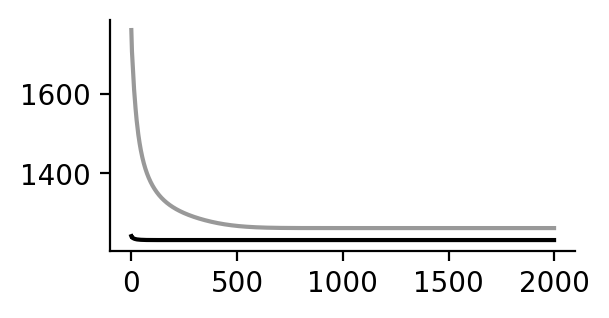

In [44]:
plt.figure(figsize = (3, 1.5))
plt.plot(loss_hist, color = '.6')
plt.plot(loss_hist_step2, 'k-')
sns.despine()

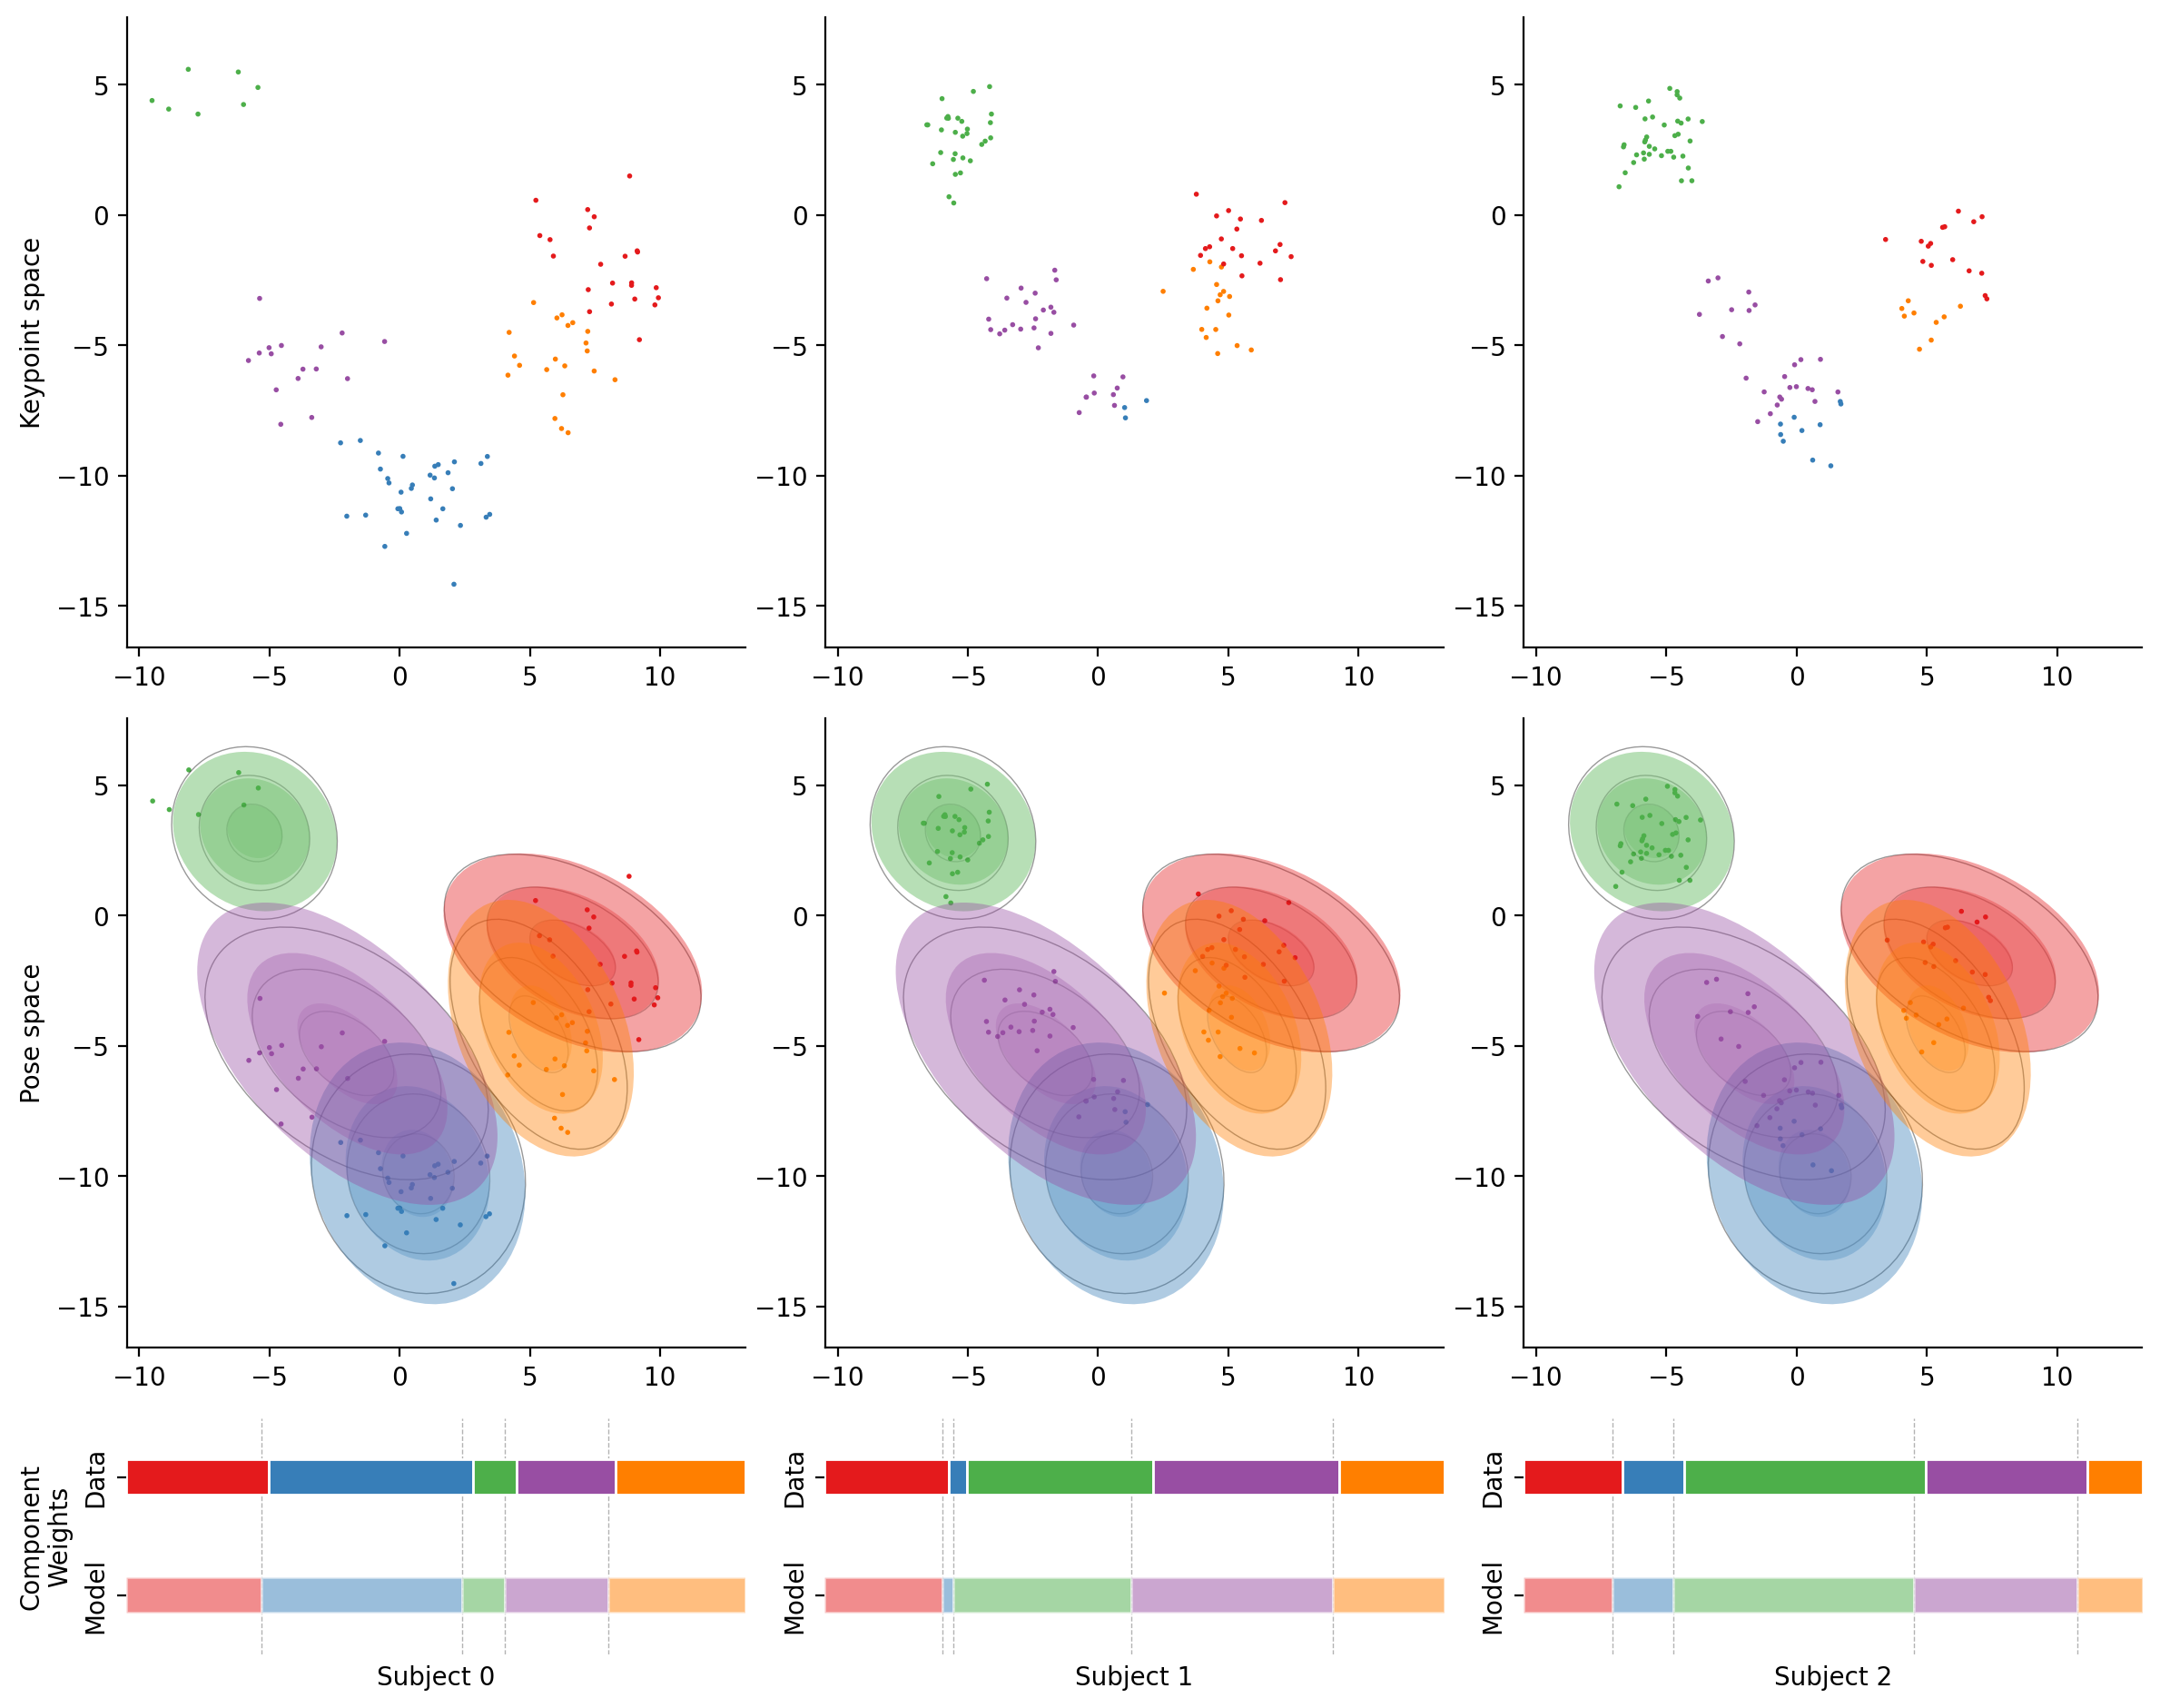

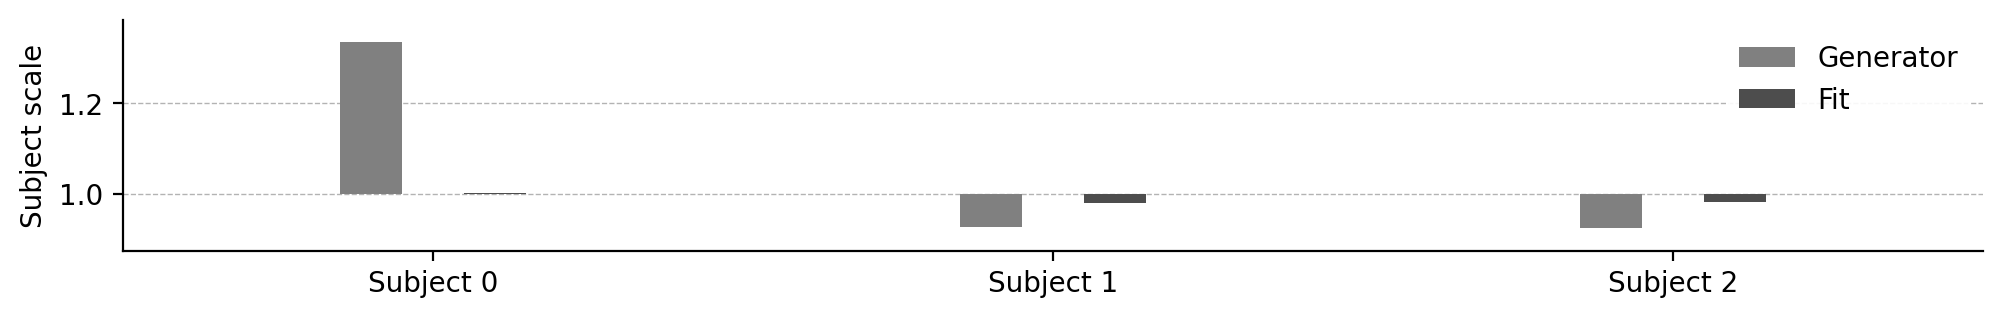

In [45]:
fig = plt.figure(figsize = (4 * pose_hyperparams.N, 8 + 1.5 + 1.5))
est_states = joint_model.latent_mle(model, gt_obs, fit_params_step2, hyperparams)
ax = mixtures.sampled_mixture_plot(fig, pose_hyperparams, fit_params_step2.posespace, est_states, gt_obs)
plt.show()

fig = plt.figure(figsize = (4 * pose_hyperparams.N, 1.5))
viz_morphs.plot_subjectwise_scalar_comparison(
    fig.gca(),
    jnp.exp(jnp.stack([gt_morph.scale_log, fit_params_step2.morph.scale_log], axis = 1)),
    ["Generator", "Fit"],)